In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [4]:
import gdown

In [5]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [6]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [7]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [8]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [9]:
char_to_num.get_vocabulary()

['',
 np.str_('a'),
 np.str_('b'),
 np.str_('c'),
 np.str_('d'),
 np.str_('e'),
 np.str_('f'),
 np.str_('g'),
 np.str_('h'),
 np.str_('i'),
 np.str_('j'),
 np.str_('k'),
 np.str_('l'),
 np.str_('m'),
 np.str_('n'),
 np.str_('o'),
 np.str_('p'),
 np.str_('q'),
 np.str_('r'),
 np.str_('s'),
 np.str_('t'),
 np.str_('u'),
 np.str_('v'),
 np.str_('w'),
 np.str_('x'),
 np.str_('y'),
 np.str_('z'),
 np.str_("'"),
 np.str_('?'),
 np.str_('!'),
 np.str_('1'),
 np.str_('2'),
 np.str_('3'),
 np.str_('4'),
 np.str_('5'),
 np.str_('6'),
 np.str_('7'),
 np.str_('8'),
 np.str_('9'),
 np.str_(' ')]

In [10]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [11]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [12]:
# Define a function to load alignments from a given path
def load_alignments(path:str) -> List[str]: 
    # Open the file in read mode and get all the lines
    with open(path, 'r') as f: 
        lines = f.readlines() 
        
    # Initialize an empty list to hold the tokens    
    tokens = []
    
    # Loop through each line in the file
    for line in lines:
        line = line.split() # Split the line into a list of words
        if line[2] != 'sil': # If the third word in the line is not 'sil'
            tokens = [*tokens,' ',line[2]] # Append a space and the third word to the tokens list
            
    # Split the tokens into individual characters, convert them to numerical values using char_to_num, and return the result
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [13]:
def load_data(path: str): 
    # Decode path from bytes to string
    path = bytes.decode(path.numpy())
    # Get the file name from the path and remove the file extension
    file_name = path.split('/')[-1].split('.')[0]
    # Build paths to video and alignment files
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    # Load video frames and text alignments
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [14]:
test_path = './ata/s1/bbal6n.mpg'

In [15]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

''

In [16]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

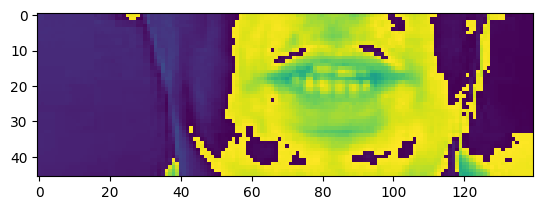

In [17]:
plt.imshow(frames[40])

In [18]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [19]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [20]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [21]:
from matplotlib import pyplot as plt

In [22]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [23]:
len(test)

50

In [24]:
frames, alignments = data.as_numpy_iterator().next()

In [25]:
len(frames)

2

In [26]:
alignments

array([[16, 12,  1,  3,  5, 39,  2, 12, 21,  5, 39,  2, 25, 39,  3, 39,
        19,  5, 22,  5, 14, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [16, 12,  1,  3,  5, 39, 18,  5,  4, 39, 23,  9, 20,  8, 39, 17,
        39, 20,  8, 18,  5,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [27]:
frames

array([[[[[ 1.2065473 ],
          [ 1.2065473 ],
          [ 1.2065473 ],
          ...,
          [ 0.44240063],
          [ 0.44240063],
          [ 0.36196417]],

         [[ 1.2065473 ],
          [ 1.2065473 ],
          [ 1.2065473 ],
          ...,
          [ 0.4021824 ],
          [ 0.36196417],
          [ 0.36196417]],

         [[ 1.2065473 ],
          [ 1.2065473 ],
          [ 1.2065473 ],
          ...,
          [ 0.2010912 ],
          [ 0.32174593],
          [ 0.2010912 ]],

         ...,

         [[ 0.88480127],
          [ 0.88480127],
          [ 0.88480127],
          ...,
          [ 0.9250195 ],
          [ 1.0456742 ],
          [ 0.9250195 ]],

         [[ 0.84458303],
          [ 0.84458303],
          [ 0.84458303],
          ...,
          [ 0.72392833],
          [ 0.9250195 ],
          [ 0.88480127]],

         [[ 0.84458303],
          [ 0.84458303],
          [ 0.84458303],
          ...,
          [ 0.76414657],
          [ 0.9250195 ],
          

In [28]:
sample = data.as_numpy_iterator()

In [29]:
val = sample.next(); val[0]

array([[[[[ 1.3836881 ],
          [ 1.3836881 ],
          [ 1.4650815 ],
          ...,
          [10.377661  ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.3836881 ],
          [ 1.3836881 ],
          [ 1.4650815 ],
          ...,
          [10.377661  ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.3836881 ],
          [ 1.3836881 ],
          [ 1.3836881 ],
          ...,
          [10.336964  ],
          [10.336964  ],
          [10.336964  ]],

         ...,

         [[ 0.9360243 ],
          [ 0.9360243 ],
          [ 0.9360243 ],
          ...,
          [10.13348   ],
          [10.13348   ],
          [10.13348   ]],

         [[ 0.9360243 ],
          [ 0.9360243 ],
          [ 0.9360243 ],
          ...,
          [10.092784  ],
          [10.092784  ],
          [10.092784  ]],

         [[ 0.9360243 ],
          [ 0.9360243 ],
          [ 0.9360243 ],
          ...,
          [10.092784  ],
          [10.092784  ],
          

In [30]:
# Extract frames and prepare for GIF creation
frames = []
for frame in val[0][0]:
    # Remove the last dimension to get shape (46, 140)
    frame = frame.squeeze(-1)
    
    # If frame is float32, scale it to 0-255 and convert to uint8
    if frame.dtype == np.float32:
        frame = (frame * 255).clip(0, 255).astype(np.uint8)
    frames.append(frame)

# Save the frames as a GIF
imageio.mimsave('/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/animation.gif', frames, fps=10)

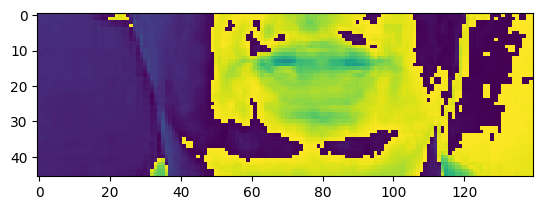

In [31]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [32]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set white by v five again'>

# 3. Design the Deep Neural Network

In [33]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [34]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [35]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
5*17*75

6375

In [38]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [39]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'qqpppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp222'>

In [40]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'qqpppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp222'>

In [41]:
model.input_shape

(None, 75, 46, 140, 1)

In [42]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [43]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [44]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [45]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [46]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [47]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint1.weights.h5'), monitor='loss', save_weights_only=True) 

In [48]:
schedule_callback = LearningRateScheduler(scheduler)

In [49]:
example_callback = ProduceExample(test)

In [50]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [51]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


I0000 00:00:1731441073.841568  193843 service.cc:148] XLA service 0x30645b780 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731441073.841728  193843 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1731441073.873027  193843 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-11-13 01:21:15.674524: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-11-13 01:21:15.674745: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-11-13 01:21:15.674760: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-11-13 01:21:15.674781: W 

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/time_distributed_1/Reshape_3 defined at (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/var/folders/70/_xc8h2gj12b_8vjmwzk16r640000gn/T/ipykernel_8137/3536403359.py", line 1, in <module>

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/models/sequential.py", line 213, in call

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/models/functional.py", line 182, in call

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/models/functional.py", line 584, in call

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/layers/rnn/time_distributed.py", line 108, in call

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/layers/rnn/time_distributed.py", line 108, in <listcomp>

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/layers/rnn/time_distributed.py", line 102, in step_function

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/ops/numpy.py", line 4728, in reshape

  File "/Users/raman/Desktop/Deep Learning/lipread_tensorflow-main/env/lib/python3.9/site-packages/keras/src/backend/tensorflow/numpy.py", line 1851, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1/time_distributed_1/Reshape_3}}]] [Op:__inference_one_step_on_iterator_31254]

# 5. Make a Prediction 

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
checkpoint = tf.train.Checkpoint(model=model)

# Restore the checkpoint (replace 'checkpoint' with the path to the directory containing your checkpoint files)
checkpoint.restore('checkpoints/checkpoint').expect_partial()

# You can now use the model for prediction or further training
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_18 (Conv3D)              │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_18 (MaxPooling3D) │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_19 (Conv3D)              │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_19 (MaxPooling3D) │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_20 (Conv3D)              │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_20 (MaxPooling3D) │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 75, 256)        │     6,660,096 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 75, 256)        │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,415,774 (96.95 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,943,850 (64.64 MB)

In [ ]:
# model.load_weights('checkpoints/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

[mpeg1video @ 0x35c0d2440] ac-tex damaged at 22 17
[mpeg1video @ 0x35c0d2440] Warning MVs not available


In [ ]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white in b four please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay red with f zero now'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'xhdj'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b"t'rdj5">]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'?h?h?hje'>]